In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import datetime as dt
from metloom.pointdata import MesowestPointData, SnotelPointData
from datetime import datetime
from metloom.variables import SnotelVariables, SensorDescription

import cdsapi
import os
import json
import cfgrib
from datetime import date
from datetime import datetime
import xarray as xr


import requests


In [ ]:
def normalize_data(df):
    '''Normalized a pandas series'''
    norm = (df - df.mean())/df.std()
    norm.index = norm.index.astype(int)
    return norm

In [95]:
# Gets monthly soil temperature and soil moisture data from these three site names using the files listed
files = [
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STO/CO/Schofield%20Pass.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STM/CO/Schofield%20Pass.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STO/CO/Park%20Cone.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STM/CO/Park%20Cone.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STO/CO/Butte.csv",
    "https://www.nrcs.usda.gov/Internet/WCIS/AWS_PLOTS/siteCharts/POR/STM/CO/Butte.csv",
]

site_names = ["Schofield Pass", "Park Cone", "Butte"]
elements = ["STO", "STM"]
ersoilsdict = {}
counter = 0
for i, site in enumerate(site_names):
    try:
        ersoilsdict[site] = {elements[0]:pd.read_csv(files[counter]), elements[1]:pd.read_csv(files[counter+1])}
        counter+=2
    except: 
        ersoilsdict[site] = {elements[0]:pd.read_csv(files[counter]), elements[1]:None}
        counter+=2



In [201]:
# pull in desired ERA5 data
era51821 = xr.open_dataset("../../../../../../storage/dlhogan/sos/data/ERA5/2018_to_2021.grib", engine="cfgrib")

skipping variable: paramId==182 shortName='e'
Traceback (most recent call last):
  File "/home/dlhogan/.conda/envs/sos_env1/lib/python3.9/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/dlhogan/.conda/envs/sos_env1/lib/python3.9/site-packages/cfgrib/dataset.py", line 607, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1514764800, 1517443200, 1519862400, 1522540800, 1525132800,
       1527811200, 1530403200, 1533081600, 1535760000, 1538352000,
       1541030400, 1543622400, 1546300800, 1548979200, 1551398400,
       1554076800, 1556668800, 1559347200, 1561939200, 1564617600,
       1567296000, 1569888000, 1572566400, 1575158400, 1577836800,
       1580515200, 1583020800, 1585699200, 1588291200, 1590969600,
       1593561600, 1596240000, 1598918400, 1601510400, 1604188800,
       16067

This API pulls relevant snotel data from the desired locations (20-inch moisture specifically). Now I will organize each site into a single dataframe

In [109]:
er_sntl_ds = xr.open_dataset('../../../../../../storage/dlhogan/sos/data/east_river_sntl_20220930.nc')


The API pull provides 50 cm temperature and soil moisture

Now I have billy bar climatology for each month going back to 1975

In [126]:
bb_climatology = pd.read_csv('../../data/billy_barr_monthly_avg.csv',sep='\t')
bb_climatology[bb_climatology==" "] = np.nan
bb_climatology['WY'] = [int(str(year)[0:2]+str(year)[4:]) for year in bb_climatology['Year']]

In [141]:
er_sntl_ds = er_sntl_ds.where(er_sntl_ds['SMS']<=100, np.nan)

<AxesSubplot: >

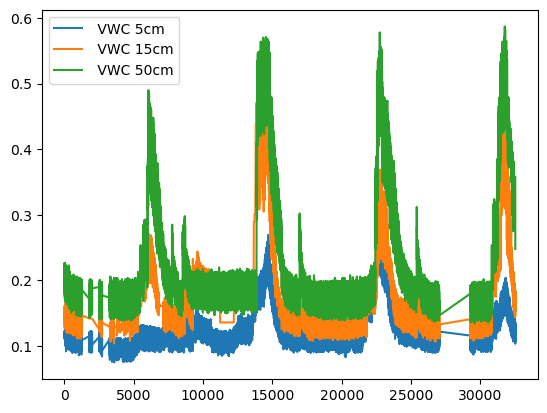

In [170]:
df = pd.read_csv("../../data/carbone_rmbl_2011_2015_SM.csv", sep='\t')
df = df[['Year',' Month', ' Day', ' Hour', ' VWC 5cm',' VWC 15cm',' VWC 50cm']].dropna()
rmblsm_df[[' VWC 5cm',' VWC 15cm', ' VWC 50cm']].plot()

In [182]:
years = [yr.replace('.0','') for yr in df.Year.astype(str)]
months = [mo.replace('.0','') for mo in df[' Month'].astype(str)]
for i,mo in enumerate(months):
    if int(mo) < 10:
        months[i] = '0'+mo
days = [dy.replace('.0','') for dy in df[' Day'].astype(str)]
for i,day in enumerate(days):
    if int(day) < 10:
        days[i] = '0'+day
hours = [hr.replace('.0','') for hr in df[' Hour'].astype(str)]
for i,hr in enumerate(hours):
    if int(hr) < 10:
        hours[i] = '0'+hr

dates = []
for i in range(len(years)):
    d = years[i] + months[i] + days[i] +' '+ hours[i]
    dates.append(datetime.strptime(d,'%Y%m%d %H'))
df.index = dates

In [214]:
# Still need to do some data cleaning here and create a continuous dataset
monthly_mean_sm_butte = er_sntl_ds.isel(Location=0)['SMS'].resample(Date='M').median()
monthly_mean_sm_parkcone = er_sntl_ds.isel(Location=1)['SMS'].resample(Date='M').median()
monthly_mean_sm_schofield_pass = er_sntl_ds.isel(Location=2)['SMS'].resample(Date='M').median()

norm_sm_butte = (monthly_mean_sm_butte - monthly_mean_sm_butte.mean())/monthly_mean_sm_butte.std()
norm_sm_parkcone = (monthly_mean_sm_parkcone - monthly_mean_sm_parkcone.mean())/monthly_mean_sm_parkcone.std()
norm_sm_schofield_pass = (monthly_mean_sm_schofield_pass - monthly_mean_sm_schofield_pass.mean())/monthly_mean_sm_schofield_pass.std()

In [268]:
kp_coords = [38.94182, -106.97298]
era5_er_sm = era51821.sel(latitude=kp_coords[0], longitude=kp_coords[1], method='nearest')['swvl1'].resample(time='M').mean()
norm_era5_er_sm = (era5_er_sm - era5_er_sm.mean())/era5_er_sm.std()

In [226]:
ds = xr.open_mfdataset('../../../../../../storage/dlhogan/sos/data/merra_2/*')



In [269]:
merra2_er_sm = ds.sel(lat=kp_coords[0], lon=kp_coords[1], method='nearest')['GWETPROF'].resample(time='M').mean()
norm_merra2_er_sm = (merra2_er_sm - merra2_er_sm.mean())/merra2_er_sm.std()

Text(0.5, 1.0, 'Daily SNOTEL Soil Moisture')

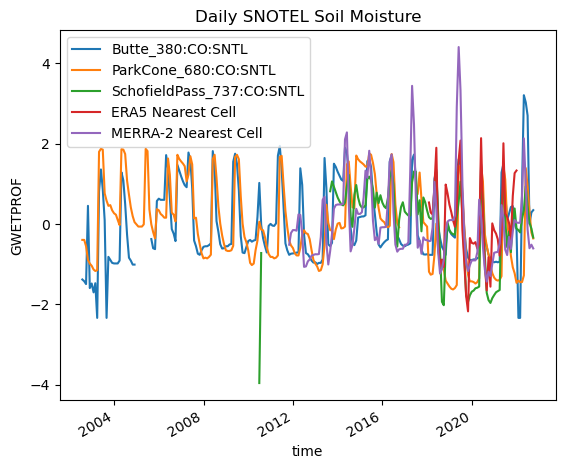

In [270]:
norm_sm_butte.plot(label=er_sntl_ds.isel(Location=0)['Location'].values)
norm_sm_parkcone.plot(label=er_sntl_ds.isel(Location=1)['Location'].values)
norm_sm_schofield_pass.plot(label=er_sntl_ds.isel(Location=2)['Location'].values)
norm_era5_er_sm.plot(label='ERA5 Nearest Cell')
norm_merra2_er_sm.plot(label='MERRA-2 Nearest Cell')
plt.legend()
plt.title('Daily SNOTEL Soil Moisture')

In [271]:

df = pd.concat([norm_merra2_er_sm.to_pandas(),
                norm_era5_er_sm.to_pandas(),
                norm_sm_butte.to_pandas(),
                norm_sm_parkcone.to_pandas(),
                norm_sm_schofield_pass.to_pandas()],
                axis=1, 
                )
df = df.rename(columns=dict(zip(df.columns,['merra2','era5','butte','parkcone','schofieldpass'])))

In [ ]:
# can use this to try and get a pearson coefficient 
# https://stackoverflow.com/questions/59326121/add-regression-line-in-the-scatter-matrix-of-pandas
# from scipy.stats import pearsonr
# def reg_coef(x,y,label=None,color=None,**kwargs):
#     ax = plt.gca()
#     r,p = pearsonr(x,y)
#     ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
#     ax.set_axis_off()

# iris = sns.load_dataset("iris")
# g = sns.PairGrid(iris)
# g.map_diag(sns.distplot)
# g.map_lower(sns.regplot)
# g.map_upper(reg_coef)

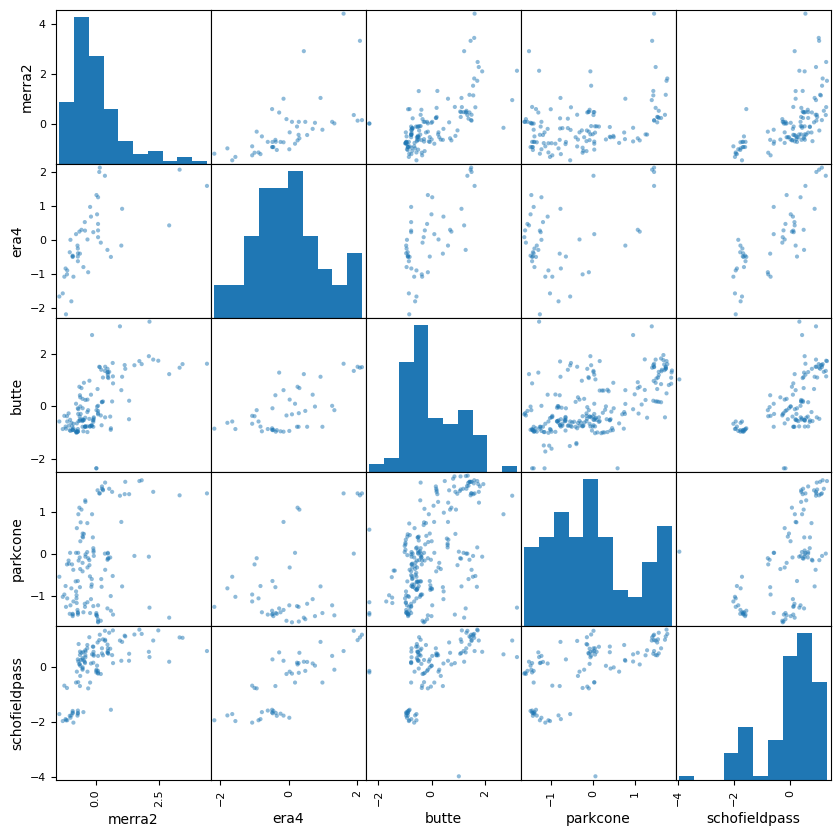

In [275]:
pd.plotting.scatter_matrix(df, figsize=(10,10));

ValueError: Length of values (2) does not match length of index (691)

array([[<AxesSubplot: xlabel='merra2', ylabel='merra2'>,
        <AxesSubplot: xlabel='era4', ylabel='merra2'>,
        <AxesSubplot: xlabel='butte', ylabel='merra2'>,
        <AxesSubplot: xlabel='parkcone', ylabel='merra2'>,
        <AxesSubplot: xlabel='schofieldpass', ylabel='merra2'>],
       [<AxesSubplot: xlabel='merra2', ylabel='era4'>,
        <AxesSubplot: xlabel='era4', ylabel='era4'>,
        <AxesSubplot: xlabel='butte', ylabel='era4'>,
        <AxesSubplot: xlabel='parkcone', ylabel='era4'>,
        <AxesSubplot: xlabel='schofieldpass', ylabel='era4'>],
       [<AxesSubplot: xlabel='merra2', ylabel='butte'>,
        <AxesSubplot: xlabel='era4', ylabel='butte'>,
        <AxesSubplot: xlabel='butte', ylabel='butte'>,
        <AxesSubplot: xlabel='parkcone', ylabel='butte'>,
        <AxesSubplot: xlabel='schofieldpass', ylabel='butte'>],
       [<AxesSubplot: xlabel='merra2', ylabel='parkcone'>,
        <AxesSubplot: xlabel='era4', ylabel='parkcone'>,
        <AxesSubplot: x

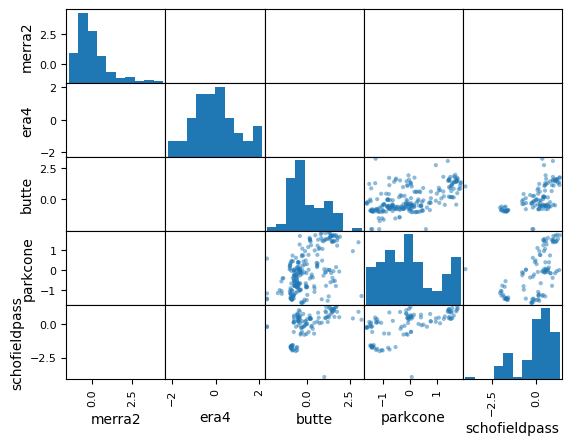

In [257]:
pd.plotting.scatter_matrix(df)

<AxesSubplot:>

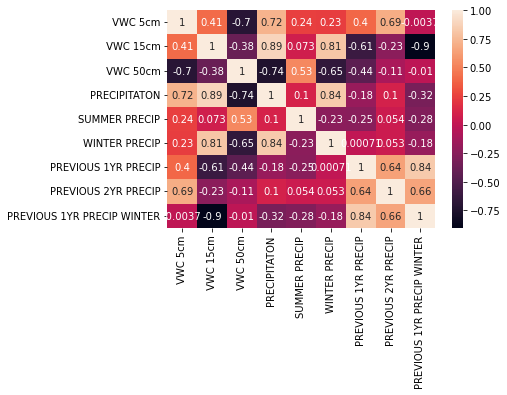

In [336]:
import seaborn as sns

sns.heatmap(pd.concat([normalize_data(summer_sm_mean[' VWC 5cm']),
normalize_data(summer_sm_mean[' VWC 15cm']),
normalize_data(summer_sm_mean[' VWC 50cm']),
butte_precip_annual,
butte_precip_summer,
butte_precip_winter,
butte_precip_previous,
butte_precip_previous2yr,
butte_precip_previous_winter], axis=1).corr(), annot=True)

In [363]:
import xarray as xr

In [380]:
myFile=r"C:\Users\dlhogan\Downloads\soil_gridMET.nc"
sm_ds = xr.open_dataset(myFile, decode_times=False)

dates = []
start = dt.date(1900,1,1)

for day in sm_ds.time.to_numpy():
    delta = dt.timedelta(day)
    offset = start + delta
    dates.append(offset)
sm_ds['time'] = pd.to_datetime(dates)

<AxesSubplot:xlabel='water_year'>

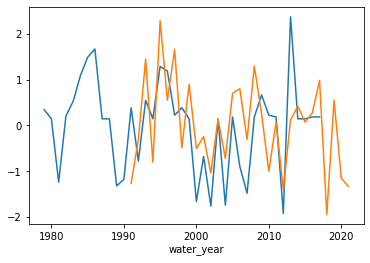

In [406]:
sm_crested_butte = sm_ds.sel(lat=38.8697, lon=-106.9878, method='nearest')
sm_crested_butte_summer = sm_crested_butte.where(sm_crested_butte['time.month'].isin([5,6,7,8,9,10,11])).soil
sm_crested_butte_summer_mean = sm_crested_butte_summer.groupby(sm_crested_butte_summer['time.year']).mean()
normalize_data(sm_crested_butte_summer_mean.to_pandas()).plot()
butte_precip_annual.plot()